In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage import io
from skimage.segmentation import mark_boundaries
from glob import glob
from matplotlib.colors import ListedColormap
import re

%matplotlib inline

In [17]:
def show_image(image_id, title=None, path='stage1_train'):
    """
    Plot colored nuclea on top of the image
    """
    image = io.imread(os.path.join(path, image_id, 'images', image_id + '.png'))[:, :, :3]
    masks = glob(os.path.join(path, image_id, 'masks', '*.png'))
    
    rand_cmap = ListedColormap(np.random.rand(len(masks), 3))
    masked_canvas = np.zeros(image.shape[:3])
    
    for i, mask_path in enumerate(glob(os.path.join(path, image_id, 'masks', '*.png'))):
        mask = io.imread(mask_path, as_grey=True)
        masked_canvas[mask > 0] = i
        
    plt.figure(figsize=(20, 20))
    transparent_canvas = np.where(masked_canvas > 0, masked_canvas, np.nan)
    
    if title:
        plt.title(title)        
    
    plt.imshow(image)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.imshow(transparent_canvas, cmap=rand_cmap)
    
def show_images(image_ids, path='stage1_train'):
    for image_id in image_ids:
        show_image(image_id, path)

def show_images_with_title(df, path='stage1_train'):
    for idx, row in df.iterrows():
        show_image(row['image_id'], row['image_id'] + ', ' + str(row['mask_count']) + ' masks', path)
        
def build_labels_df_from_path(path):
    ids = []
    id_extractor = re.compile(path + '\/(?P<image_id>.*)\/masks\/(?P<mask_id>.*)\.png')
    for path in glob(path + '/**/masks/*.png'):
        matches = id_extractor.match(path)
        image_id = matches.group('image_id')
        mask_id = matches.group('mask_id')
        mask = io.imread(path, mode='L')
        ids.append([image_id, mask_id, mask.shape[0], mask.shape[1]])
        
    return pd.DataFrame(ids, columns=['image_id', 'mask_id', 'height', 'width'])

def build_test_df_from_path(path):
    ids = []
    id_extractor = re.compile(path + '\/(?P<image_id>.*)\/images\/.*\.png')
    for path in glob(path + '/**/images/*.png'):
        matches = id_extractor.match(path)
        image_id = matches.group('image_id')
        image = io.imread(path, mode='L')
        ids.append([image_id, image.shape[0], image.shape[1]])
        
    return pd.DataFrame(ids, columns=['image_id', 'height', 'width'])

In [11]:
train = io.imread_collection('stage1_train/**/images/*.png')
test = io.imread_collection('stage1_test/**/images/*.png')
train_masks = io.imread_collection('stage1_train/**/masks/*.png')

In [12]:
len(train), len(test), len(train_masks)

(664, 65, 28993)

In [13]:
train_labels_df = build_labels_df_from_path('stage1_train')

In [14]:
train_labels_df.shape

(28993, 4)

In [15]:
train_labels_df.head()

,image_id,mask_id,height,width
0,2cfa857e63be1b418c91ad5ea1f8d136fd1b80fc856e1d...,76e4c826a60fc98921b300aa35d561727c50d3db120133...,256,256
1,2cfa857e63be1b418c91ad5ea1f8d136fd1b80fc856e1d...,e01e012627708564fd3ca492ca87a37c82bb4b398eb08e...,256,256
2,2cfa857e63be1b418c91ad5ea1f8d136fd1b80fc856e1d...,573bf5faad0d0767c31c297b7b02797ec7585f7b2f5240...,256,256
3,2cfa857e63be1b418c91ad5ea1f8d136fd1b80fc856e1d...,49c90b7c3d6ed59f881ce9c0f0ff67f906f791f39727b2...,256,256
4,2cfa857e63be1b418c91ad5ea1f8d136fd1b80fc856e1d...,01cc9a26c9129026ac6a2cfedc30241a3a45eb77803cf7...,256,256


In [23]:
train_labels_df[['height', 'width']].describe()

,height,width
count,28993.000000,28993.000000
mean,403.365054,504.112303
std,188.265545,283.473414
min,256.000000,256.000000
25%,256.000000,256.000000
50%,260.000000,347.000000
75%,520.000000,696.000000
max,1040.000000,1388.000000


In [18]:
test_df = build_test_df_from_path('stage1_test')

In [19]:
test_df.shape

(65, 3)

In [20]:
test_df.head()

,image_id,height,width
0,fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...,256,256
1,f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002...,520,696
2,472b1c5ff988dadc209faea92499bc07f305208dbda29d...,512,680
3,7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4...,256,256
4,da6c593410340b19bb212b9f6d274f95b08c0fc8f2570c...,512,680


In [22]:
test_df[['height', 'width']].describe()

,height,width
count,65.000000,65.000000
mean,402.676923,393.184615
std,129.082956,189.813386
min,256.000000,161.000000
25%,256.000000,256.000000
50%,512.000000,256.000000
75%,519.000000,640.000000
max,524.000000,696.000000


In [8]:
mask_counts = train_labels_df.groupby('image_id')[['mask_id']].count()
mask_counts = mask_counts.reset_index()
mask_counts.columns = ['image_id', 'mask_count']

In [9]:
mask_counts.sort_values('mask_count', ascending=False)

,image_id,mask_count
421,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,375
42,0ea221716cf13710214dcd331a61cea48308c3940df1d2...,369
21,07fb37aafa6626608af90c1e18f6a743f29b6b233d2e42...,313
89,20b20ab049372d184c705acebe7af026d3580f5fd5a72e...,289
245,5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b9375...,272
375,8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177...,260
226,547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3c...,257
520,c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf...,253
538,cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3...,250
303,6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbac...,206


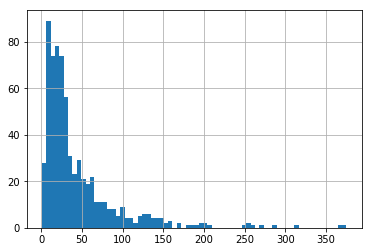

In [10]:
mask_counts['mask_count'].hist(bins=70)

[ 1.  2.  3. ... nan nan nan]


/home/r00t/.pyenv/versions/3.6.4/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


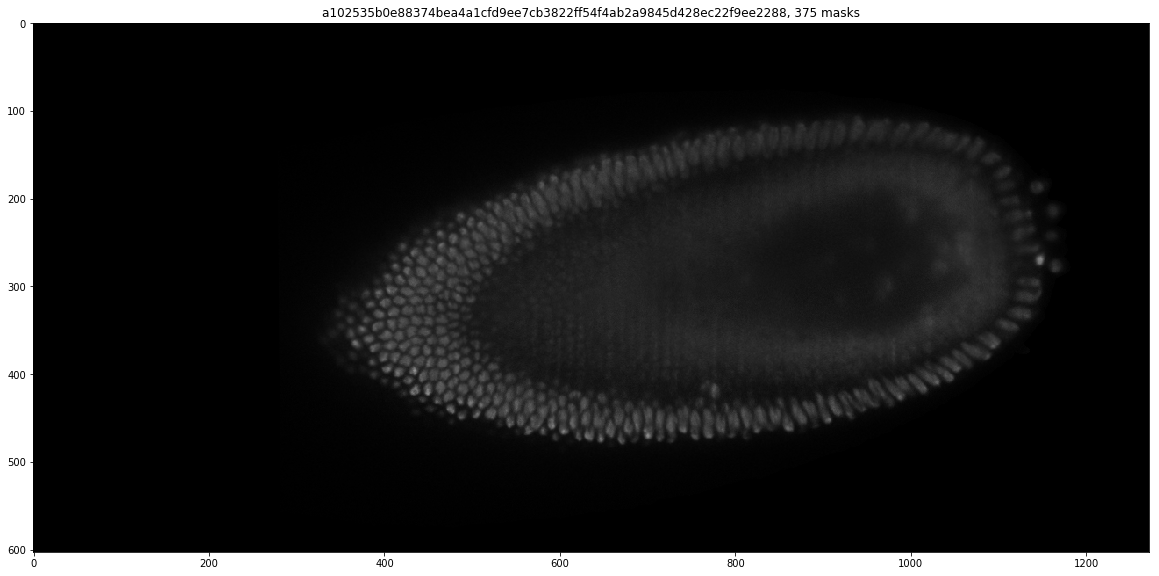

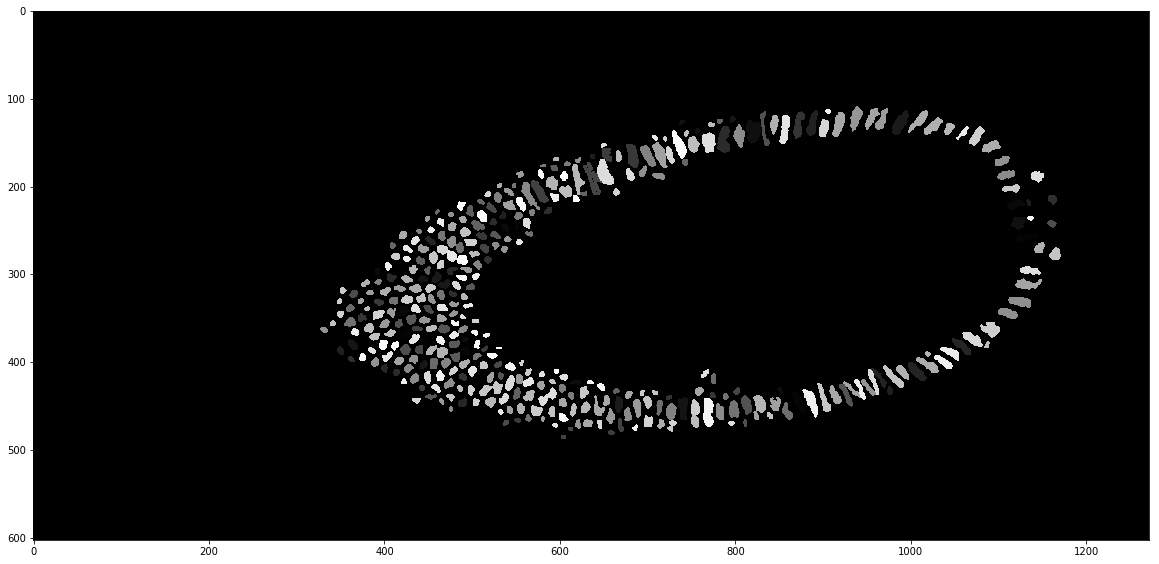

In [41]:
show_images_with_title(mask_counts.sort_values('mask_count', ascending=False)[:1])